In [ ]:
#importing libraries

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime


In [ ]:
#Read the csv file
df = pd.read_csv('/content/GE.csv')
print(df.head()) #7 columns, including the Date.

         Date       Open       High        Low      Close  Adj Close   Volume
0  2022-08-30  59.921936  60.249805  58.024979  58.649494  58.422867  5495874
1  2022-08-31  58.868073  59.164715  57.267761  57.330212  57.108681  8199681
2  2022-09-01  57.181889  57.181889  55.761124  57.049179  56.828735  6386426
3  2022-09-02  57.603436  58.048401  56.291958  56.541763  56.323277  5171397
4  2022-09-06  56.596409  56.705700  55.534737  56.330990  56.113323  5165889


In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

236   2023-08-09
237   2023-08-10
238   2023-08-11
239   2023-08-14
240   2023-08-15
241   2023-08-16
242   2023-08-17
243   2023-08-18
244   2023-08-21
245   2023-08-22
246   2023-08-23
247   2023-08-24
248   2023-08-25
249   2023-08-28
250   2023-08-29
Name: Date, dtype: datetime64[ns]


In [ ]:

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [ ]:
# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [ ]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [ ]:
#In my case, trainX has a shape (12809, 14, 5).
#12809 because we are looking back 14 days (12823 - 14 = 12809).
#Remember that we cannot look back 14 days until we get to the 15th day.
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but
#it needs multiple variables (5 in my example) to make this prediction.
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have.
#We need to predict all variables if we want to do that.

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
14/14 [==============================] - 4s 48ms/step - loss: 0.4913 - val_loss: 0.6547
Epoch 2/5
14/14 [==============================] - 0s 17ms/step - loss: 0.1650 - val_loss: 0.0230
Epoch 3/5
14/14 [==============================] - 0s 17ms/step - loss: 0.0761 - val_loss: 0.0670
Epoch 4/5
14/14 [==============================] - 0s 17ms/step - loss: 0.0787 - val_loss: 0.0127
Epoch 5/5
14/14 [==============================] - 0s 18ms/step - loss: 0.0673 - val_loss: 0.0069


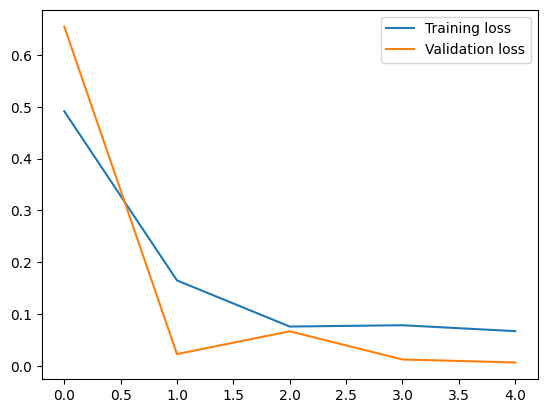

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2023-08-08 00:00:00', freq='C'), Timestamp('2023-08-09 00:00:00', freq='C'), Timestamp('2023-08-10 00:00:00', freq='C'), Timestamp('2023-08-11 00:00:00', freq='C'), Timestamp('2023-08-14 00:00:00', freq='C'), Timestamp('2023-08-15 00:00:00', freq='C'), Timestamp('2023-08-16 00:00:00', freq='C'), Timestamp('2023-08-17 00:00:00', freq='C'), Timestamp('2023-08-18 00:00:00', freq='C'), Timestamp('2023-08-21 00:00:00', freq='C'), Timestamp('2023-08-22 00:00:00', freq='C'), Timestamp('2023-08-23 00:00:00', freq='C'), Timestamp('2023-08-24 00:00:00', freq='C'), Timestamp('2023-08-25 00:00:00', freq='C'), Timestamp('2023-08-28 00:00:00', freq='C')]


In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 321ms/step


In [ ]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']




<ipython-input-16-e568de85401c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


TypeError: ignored

In [ ]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])